**You should not change this cell.**

In [1]:
import pandas as pd
import numpy as np
import catboost
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedGroupKFold, GroupKFold
import gc

train = pd.read_csv('/kaggle/input/ioai-2025-preparation-class-lesson-3-homework/train.csv')
train = train.sample(frac = 1.0, random_state = 322).reset_index(drop = True)
test = pd.read_csv('/kaggle/input/ioai-2025-preparation-class-lesson-3-homework/test.csv')
sample_submission = pd.read_csv('/kaggle/input/ioai-2025-preparation-class-lesson-3-homework/sample_submission.csv')

def lgb_train(train, target, split_list, param):
    
    bst_list = []
    for i , (train_index, test_index) in enumerate(split_list):
        tr = catboost.Pool(train[train_index], label = target[train_index])
        te = catboost.Pool(train[test_index], label = target[test_index])
        
        bst = catboost.train(tr, param, eval_set = te, iterations = 4000, early_stopping_rounds = 300, verbose =300)
        bst_list += [bst]

        gc.collect()
        del tr, te
    
    return bst_list

params_cat = {
    'loss_function' :'MultiClass', 
    'task_type' : 'GPU', 
     'max_depth' : 4, 
    'eval_metric' :'MultiClass', 
    'learning_rate' : .1, 
    'border_count' :  127,
    'random_state' : 42 ,
}

**You can change the function "standart_split" as you want.**

In [2]:
def standart_split(data, target_column, n_splits=5, seed=322):
    group_column = "session_id"
    split_list = []
    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    target = data['target']
    groups = data[group_column]
    
    for train_index, val_index in sgkf.split(data, target, groups):
        split_list.append((train_index, val_index))
    return split_list

**You can change the set of training columns as you want. To do this, you must add the columns at "drop_cols" list that you do not want to use in the training.**

In [3]:
bad_cols = ['gyro_z_100_mean', 'accel_z_10_min', 'accel_y_10_mean', 'accel_y_10_median']
drop_cols = ['session_id', 'time', 'target'] + bad_cols
train_cols = [x for x in train.columns if x not in drop_cols]
print(len(train_cols))

33


**If your GPU quota has ended, uncooment this line.**

In [4]:
# params_cat['task_type'] = 'CPU'

**You should not change this cell. submission.csv generated from that cell you need to use for submit on leaderboard**

In [5]:
split_list = standart_split(train, 'target')
bst_list = lgb_train(train[train_cols].values, train['target'].values, split_list, params_cat)
pred = []
for bst in bst_list:
    pred += [bst.predict(test[train_cols], prediction_type = 'Probability') ]
sample_submission[sample_submission.columns[1:]] = np.mean(pred, 0)
sample_submission.to_csv('submission.csv', index = None)

0:	learn: 2.7498926	test: 2.7528025	best: 2.7528025 (0)	total: 13.2s	remaining: 14h 39m 48s
300:	learn: 1.2200843	test: 1.4659047	best: 1.4657231 (298)	total: 19.3s	remaining: 3m 57s
600:	learn: 1.0189378	test: 1.4545351	best: 1.4524969 (490)	total: 25.4s	remaining: 2m 23s
bestTest = 1.452496933
bestIteration = 490
Shrink model to first 491 iterations.
0:	learn: 2.7501085	test: 2.7513823	best: 2.7513823 (0)	total: 23.9ms	remaining: 1m 35s
300:	learn: 1.2014495	test: 1.5336081	best: 1.5328412 (282)	total: 6.05s	remaining: 1m 14s
600:	learn: 1.0008115	test: 1.5383288	best: 1.5292145 (414)	total: 12.1s	remaining: 1m 8s
bestTest = 1.52921447
bestIteration = 414
Shrink model to first 415 iterations.
0:	learn: 2.7502659	test: 2.7469780	best: 2.7469780 (0)	total: 23ms	remaining: 1m 32s
300:	learn: 1.2063259	test: 1.5143451	best: 1.5140731 (298)	total: 6.1s	remaining: 1m 14s
600:	learn: 1.0081177	test: 1.5047211	best: 1.5041737 (556)	total: 12.2s	remaining: 1m 8s
900:	learn: 0.8792708	test: 1.

# EDA

### Меня если что зовут Вершинин Михаил

## Отсев колонок

### Ну тут как бы прям по семинару: что в классификации train и test очень помогает - то и выкидываем

In [6]:
train['fact'] = 0
test['fact'] = 1
all_in_one = pd.concat([train.drop(columns=['target']), test.drop(columns=['target'])], ignore_index=True).drop(columns=['session_id', 'time'])

In [7]:
X = all_in_one.drop(columns=['fact'])
y = all_in_one['fact']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
cb = catboost.CatBoostClassifier(iterations=2000, **params_cat)
cb.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=500, early_stopping_rounds=300)
accuracy_score(y_test, cb.predict(X_test))

0:	learn: 0.5981982	test: 0.5981965	best: 0.5981965 (0)	total: 6.84ms	remaining: 13.7s
500:	learn: 0.0001985	test: 0.0001461	best: 0.0001461 (500)	total: 2.43s	remaining: 7.28s
1000:	learn: 0.0001754	test: 0.0001267	best: 0.0001267 (1000)	total: 4.83s	remaining: 4.82s
1500:	learn: 0.0001656	test: 0.0001177	best: 0.0001177 (1495)	total: 7.24s	remaining: 2.41s
1999:	learn: 0.0001614	test: 0.0001145	best: 0.0001145 (1998)	total: 9.57s	remaining: 0us
bestTest = 0.0001144876594
bestIteration = 1998
Shrink model to first 1999 iterations.


0.999961769153654

### Я думаю очевидно что точности 99% быть явно не должно, да и в importance важность первой фичи ЗНАЧИТЕЛЬНО больше, так что уберём её, ну и ещё вторую докучи

In [8]:
imps = pd.DataFrame()
imps['cols'] = X.columns
imps['imp'] = cb.get_feature_importance()
imps.sort_values('imp', ascending=False).head()

,cols,imp
19,gyro_z_100_mean,74.259162
2,accel_z_10_min,8.669750
5,accel_z_10_mean,3.724978
7,accel_z_10_median,3.318029
1,accel_z_1_min,1.727032


### Сохраняем

In [9]:
bad_cols = ['gyro_z_100_mean', 'accel_z_10_min']

### Повторяем процесс без убранных колонок

In [10]:
X = all_in_one.drop(columns=['fact'] + bad_cols)
y = all_in_one['fact']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
cb = catboost.CatBoostClassifier(iterations=2000, **params_cat)
cb.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=500, early_stopping_rounds=300)
accuracy_score(y_test, cb.predict(X_test))

0:	learn: 0.6376552	test: 0.6375373	best: 0.6375373 (0)	total: 6.72ms	remaining: 13.4s
500:	learn: 0.0960161	test: 0.0978129	best: 0.0978129 (500)	total: 2.54s	remaining: 7.61s
1000:	learn: 0.0796877	test: 0.0826275	best: 0.0826275 (1000)	total: 5.16s	remaining: 5.15s
1500:	learn: 0.0701457	test: 0.0739625	best: 0.0739625 (1500)	total: 7.82s	remaining: 2.6s
1999:	learn: 0.0626308	test: 0.0670258	best: 0.0670258 (1999)	total: 10.4s	remaining: 0us
bestTest = 0.067025788
bestIteration = 1999


0.9789305557915484

### Опять точность слишком большая, значит надо убирать: вот как раз у первых двух колонок importance очень большой, их и убираем

In [11]:
imps = pd.DataFrame()
imps['cols'] = X.columns
imps['imp'] = cb.get_feature_importance()
imps.sort_values('imp', ascending=False).head()

,cols,imp
5,accel_y_10_mean,46.018911
7,accel_y_10_median,27.929440
9,accel_y_10_min,2.917661
11,accel_x_100_min,1.707490
17,gyro_y_100_min,1.609076


In [12]:
bad_cols = ['gyro_z_100_mean', 'accel_z_10_min', 'accel_y_10_mean', 'accel_y_10_median']

In [13]:
X = all_in_one.drop(columns=['fact'] + bad_cols)
y = all_in_one['fact']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
cb = catboost.CatBoostClassifier(iterations=2000, **params_cat)
cb.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=500, early_stopping_rounds=300)
accuracy_score(y_test, cb.predict(X_test))

0:	learn: 0.6551707	test: 0.6551951	best: 0.6551951 (0)	total: 6.43ms	remaining: 12.8s
500:	learn: 0.3858294	test: 0.3877813	best: 0.3877813 (500)	total: 2.62s	remaining: 7.85s
1000:	learn: 0.3385972	test: 0.3419164	best: 0.3419164 (1000)	total: 5.23s	remaining: 5.22s
1500:	learn: 0.3033566	test: 0.3076066	best: 0.3076066 (1500)	total: 7.84s	remaining: 2.61s
1999:	learn: 0.2747249	test: 0.2796896	best: 0.2796896 (1999)	total: 10.4s	remaining: 0us
bestTest = 0.2796896372
bestIteration = 1999


0.8822999677161742

### Здесь уже точность более менее, потому что какие то случайные зависимости могут помочь классификации, поэтому больше колонки убирать не буду (ну и импортансы не различаются, то есть ничего выделяющегося)

In [14]:
imps = pd.DataFrame()
imps['cols'] = X.columns
imps['imp'] = cb.get_feature_importance()
imps.sort_values('imp', ascending=False).head()

,cols,imp
9,accel_x_100_min,8.182197
23,accel_x_100_median,7.184372
15,gyro_y_100_min,7.035884
19,gyro_z_100_min,6.865916
8,accel_z_100_min,5.958730


### Зачищаем колонки

In [15]:
train.drop(columns=['fact'], inplace=True)
test.drop(columns=['fact'], inplace=True)

## Валидация

### Мой метод валидации - StratifiedGroupKFold с стратификацией по target и группами session_id

### Разберём по очереди

### Почему стратификация по target? - потому что в колонке дисбаланс классов, что важно учитывать при разбиении

<Axes: xlabel='target', ylabel='count'>

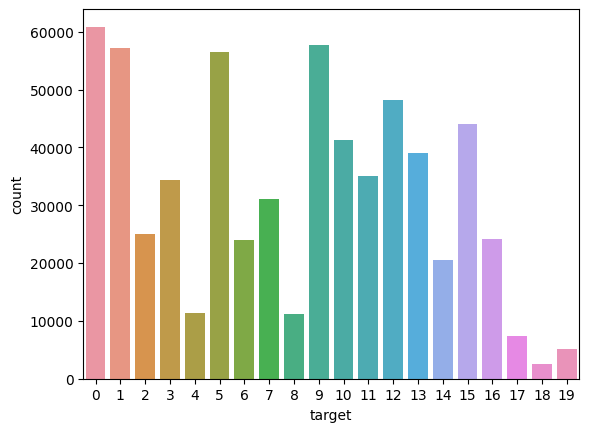

In [16]:
sns.barplot(x=train['target'].value_counts().index, y=train['target'].value_counts())

### Вот из-за такой красоты стратификация важна

### Почему группа - session_id? - Потому что группы в train и test не пересекаются, что важно учитывать при валидации

In [17]:
sum(test['session_id'].isin(train['session_id']))

0

### Ну я увы не знаю что ещё сюда добавить, потому что другие обоснования для выбора валидации не нужны

## Что-то что я не понял

### Исследуя тест, я нашёл интересную закономерность порядка time и session_id 

<Axes: ylabel='time'>

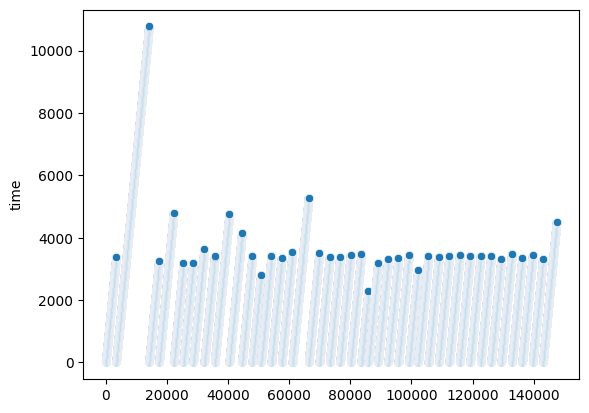

In [18]:
sns.scatterplot(test['time'])

<Axes: ylabel='session_id'>

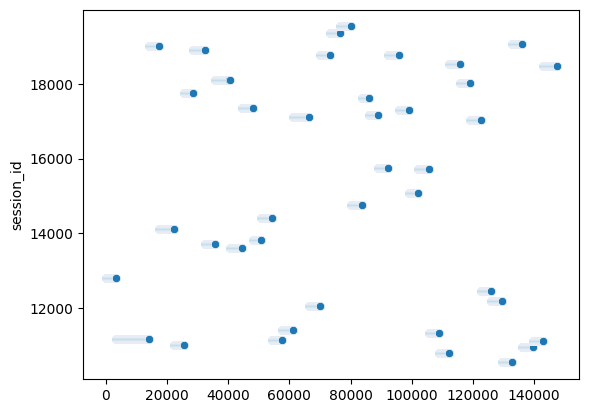

In [19]:
sns.scatterplot(test['session_id'])

### Увы я не смог понять этой закономерности, но я думаю, что если подобным образом сортировать train при валидации, то тогда точность будет выше.

### P. S. Вот закономерность которую я смог найти:

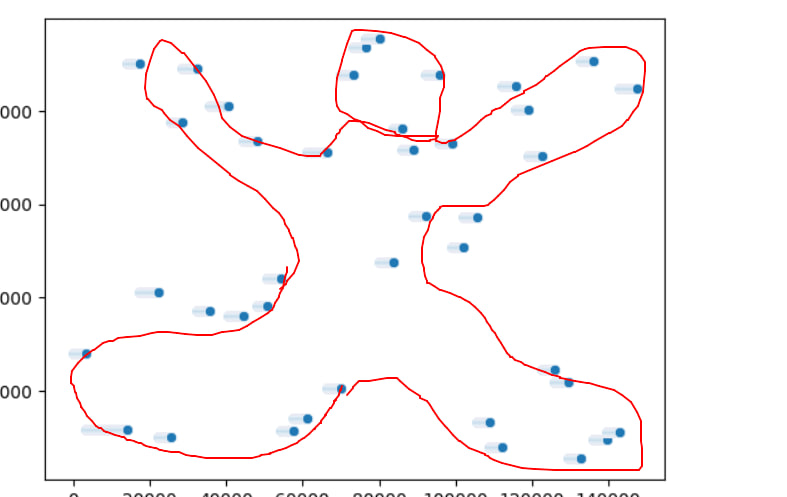
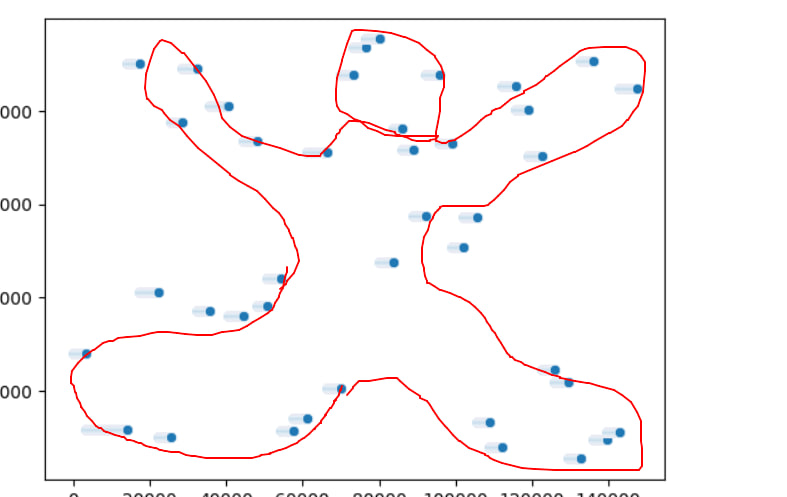
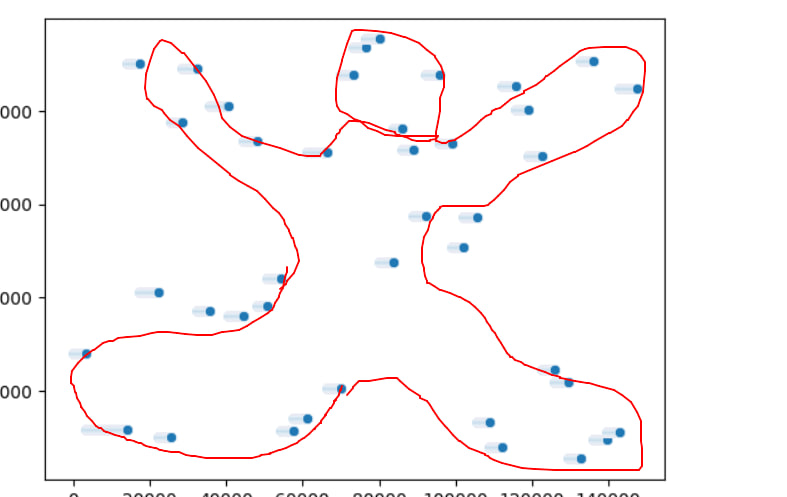

### Очень милая задача (не снижайте баллы за шутки и за то что не разгадал, трешолд я вроде прошёл ^^)